In [1]:
from __future__ import division
from IPython.display import display
from IPython.display import Markdown as md
from IPython.core.display import SVG
from sympy.interactive import printing
printing.init_printing(use_latex='mathjax')

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.odr import *
import scipy.odr.odrpack as odrpack
from uncertainties import ufloat
from uncertainties.umath import *
from uncertainties import unumpy

import sympy as sp
sf = sp.sympify

import scipy.constants as cm
import pint as pn
ureg = pn.UnitRegistry(system='mks')
ureg.default_format = '~P'
pe = ureg.parse_expression

## Konstanten und Einheiten
CM = pd.DataFrame(cm.physical_constants).T
CM['c'] = CM.index
CM = CM.reset_index(drop=True)
def getpc(quant):
    DF = CM
    DF = DF[DF['c']==quant].reset_index(drop=True)
    quan = DF[0][0] * ureg(DF[1][0])
    return quan
def addnoise(X,scale=0.01,lin=False):
    if not lin:
        mag = scale*(np.max(X.m)-np.min(X.m))
        return np.random.normal(0,mag,len(X.m))*X.u
    if lin:
        return np.random.normal(0,1,len(X.m))*X*scale
def uODR(func,beta0,xdata,ydata,**kwargs):
    xfit = kwargs.get('xfit',xdata)
    sx = kwargs.get('sx',None)
    sy = kwargs.get('sy',None)
    model = Model(func)
    data = RealData(xdata,ydata, sx=sx, sy=sy)
    odr = ODR(data, model, beta0=beta0)
    out = odr.run()
    # Estimated parameter values, of shape q
    p = out.beta
    # Standard errors of the estimated parameters, of shape p
    perr = out.sd_beta
    up =unumpy.uarray(p, perr)
    yfit=func(p, xfit) 
    return up , p, yfit, out

In [2]:
g = getpc('standard acceleration of gravity')
m_e = getpc('electron mass')
e = getpc('elementary charge')
c = getpc('speed of light in vacuum')
e0 = getpc('electric constant')
mu0 = getpc('mag. constant')

In [3]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Quellcode an/aus schalten."></form>''')

# Übungen Schwingungen II

## Aufgabe 1
https://www.leifiphysik.de/mechanik/mechanische-schwingungen/aufgabe/serienschaltung-von-federpendeln

## Aufgabe 2
Die Rückstellkraft die auf das Massestück wirkt ist die Summe aus den beiden Federkräften.
$$\begin{eqnarray}
F &=& F_{1} + F_{2}\\
&=& -D_1 s - D_2 s \\
&=& -\underbrace{D_1+D_2}_{D} \cdot s \\
\omega_0 &=& \sqrt{\frac{D}{m}} \\
f_0 &=& \frac{\omega_0}{2 \pi}
\end{eqnarray}$$

In [4]:
D_1 = pe('3N/cm')
D_2 = pe('2N/cm')
m = pe('2kg')

D = D_1 + D_2

omega = np.sqrt(D/m).to('Hz')
f = omega/(2*np.pi)

md("Gegeben: <br/>"
+ " $D_1 = {:~P}$".format(D_1) 
+ "; $D_2 = {:~P}$".format(D_2)  
+ "<br/>Lösung:<br/>" 
+ "$D = {:.3~P}$".format(D)
+ "; $\\omega_0 = {:.3~P}$".format(omega)
+ "; $f_0 = {:.3~P}$".format(f))

Gegeben: <br/> $D_1 = 3.0 N/cm$; $D_2 = 2.0 N/cm$<br/>Lösung:<br/>$D = 5.0 N/cm$; $\omega_0 = 15.8 Hz$; $f_0 = 2.52 Hz$

## Aufgabe 3
Die Geschwindigkeit eines harmonischen Oszillators ist bekannt durch:
$$v(t) = \hat{s} \omega_0 \cos{(\omega_0 t)}$$
Die halbe maximale Geschwindigkeit wird bei $\cos{\omega_0 t} = \frac{1}{2}$ für $\omega_0 t = \frac{\pi}{3}$ erreicht. Bei der Amplitude $\sin{\left(\frac{\pi}{3}\right)}\hat{s}=\frac{\sqrt{3}}{2}\hat{s} \approx 0.866 \hat{s}$ und zum Zeitpunkt $t = \frac{\pi}{3 \omega_0}$ hat die Geschwindigkeit den halben maximalen Wert.

## Aufgabe 4
Die Frequenz eines harmonischen Pendels ist:
$$f_0(m) = \frac{\sqrt{\tfrac{D}{m}}}{2 \pi}$$
Daraus folgt für das Verhältnis der Eigenfrequenzen zweier harmonischer Pendel mit unterschiedlicher Masse und gleicher Federkonstante:
$$\begin{eqnarray}
\frac{f_0(m_2)}{f_0(m_1)} &=& \sqrt{\frac{m_1}{m_2}} \\
&=& \sqrt{\frac{m}{m + \Delta m}}\\
m &=& \frac{\left(\tfrac{f_0(m_2)}{f_0(m_1)}\right)^2 \cdot \Delta m}{1- \left(\tfrac{f_0(m_2)}{f_0(m_1)}\right)^2}
\end{eqnarray}$$

In [5]:
f_1 = pe('0.88 Hz')
f_2 = pe('0.48 Hz')
dm = pe('1.25kg')

m = ((f_2/f_1)**2*dm)/(1-(f_2/f_1)**2)

md("Gegeben: <br/>"
+ " $f_{{0}}(m_1) = {:~P}$".format(f_1) 
+ "; $f_{{0}}(m_2) = {:~P}$".format(f_2) 
+ "; $\\Delta m = {:~P}$".format(dm) 
+ "<br/>Lösung:<br/>" 
+ "$m = {:.3~P}$".format(m))

Gegeben: <br/> $f_{0}(m_1) = 0.88 Hz$; $f_{0}(m_2) = 0.48 Hz$; $\Delta m = 1.25 kg$<br/>Lösung:<br/>$m = 0.529 kg$

## Aufgabe 5
### a)
Mit gegebener Frequenz $f$ und Masse $m$ berechnet man die Federkonstante $$D = \left ( 2 \pi f \right )^2 m $$.

In [6]:
f = pe('3.5 Hz')
m = pe('240g')
omega = 2 * np.pi * f

D = (omega**2 * m).to('N/m')

md("Gegeben: <br/>"
+ " $f = {:~P}$".format(f) 
+ "; $m = {:~P}$".format(m)  
+ "<br/>Lösung:<br/>" 
+ "$D = {:.4~P}$".format(D))

Gegeben: <br/> $f = 3.5 Hz$; $m = 240 g$<br/>Lösung:<br/>$D = 116.1 N/m$

### b)
Die größte potentielle Energie liegt bei der größten Auslenktung der Feder vor.
$$W_{{\mathrm{{max}}}} = \frac{1}{2} D \hat{s}^2$$

In [7]:
f = pe('3.5 Hz')
m = pe('240g')
sm = pe('4.5cm')
omega = 2 * np.pi * f

D = (omega**2 * m).to('N/m')
W = (0.5 *D * sm**2).to('J')

md("Gegeben: <br/>"
+ " $D = {:.4~P}$".format(D) 
+ "; $s= {:~P}$".format(sm)  
+ "<br/>Lösung:<br/>" 
+ "$W = {:.2~P}$".format(W))

Gegeben: <br/> $D = 116.1 N/m$; $s= 4.5 cm$<br/>Lösung:<br/>$W = 0.12 J$

## Aufgabe 6
### a)
Für die Pendellänge $l$ ergibt sich:
$$l = \frac{T^{2} g}{4 \pi^{2}}$$


In [8]:
T = pe('1s')

l = (T**2 *g /(4 *np.pi*2)).to('m')

md("Gegeben: <br/>"
+ " $T = {:~P}$".format(T) 
+ "<br/>Lösung:<br/>" 
+ "$l = {:.2~P}$".format(l))

Gegeben: <br/> $T = 1 s$<br/>Lösung:<br/>$l = 0.39 m$

### b)
Für die Periodendauer $T$ folgt:
$$T = \frac{2 \pi}{\sqrt{\frac{g}{l}}}$$

In [9]:
l = pe('1m')

T = (2 *np.pi / (np.sqrt(g/l))).to('s')

md("Gegeben: <br/>"
+ " $l = {:~P}$".format(l) 
+ "<br/>Lösung:<br/>" 
+ "$T = {:.2~P}$".format(T))

Gegeben: <br/> $l = 1 m$<br/>Lösung:<br/>$T = 2.0 s$

## Aufgabe 7
Die Rakete startet mit einer Beschleunigung $a_0$. Auf die Masse des Pendels wird eine Netto-Beschleunigung $a = a_0 + g$. Die Periodendauer $T$ ergibt sich:
$$T = \frac{2 \pi}{\sqrt{\frac{a}{l}}}$$

In [10]:
l = pe('73cm')
a_0 = pe('2.4m/s^2')

T = (2 *np.pi / (np.sqrt((a_0+g)/l))).to('s')

md("Gegeben: <br/>"
+ " $l = {:~P}$".format(l) 
+ "; $a_0 = {:~P}$".format(a_0) 
+ "<br/>Lösung:<br/>" 
+ "$T = {:.2~P}$".format(T))

Gegeben: <br/> $l = 73 cm$; $a_0 = 2.4 m/s²$<br/>Lösung:<br/>$T = 1.5 s$

## Aufgabe 8
### a)
Die kinetische Energie der Kiste ist gleich der maximalen Spannenergie der Feder:
$$\begin{eqnarray}
\frac{1}{2} m v_0^2 &=& \frac{1}{2} D \hat{s}^2 \\
v_0 &=& \hat{s} \sqrt{\frac{D}{m}}
\end{eqnarray}$$

In [11]:
s = pe('24cm')
D = pe('310N/m')
m = pe('5kg')

v = (s*np.sqrt(D/m)).to('m/s')

md("Gegeben: <br/>"
+ " $s = {:~P}$".format(s) 
+ "; $D = {:~P}$".format(D)
+ "; $m = {:~P}$".format(m)
+ "<br/>Lösung:<br/>" 
+ "$v_0 = {:.2~P}$".format(v))

Gegeben: <br/> $s = 24 cm$; $D = 310.0 N/m$; $m = 5 kg$<br/>Lösung:<br/>$v_0 = 1.9 m/s$

### b)
Die Beschleunigung die die Kiste erfährt ist nicht konstant. Vielmehr kann man sich das "Abprallen" als eine halbe Schwingung vorstellen. Damit ergibt sich für die Dauer dieses Vorgangs:
$$t = \frac{T}{2} = \pi \sqrt{\frac{m}{D}}$$

In [12]:
s = pe('24cm')
D = pe('310N/m')
m = pe('5kg')

v = (s*np.sqrt(D/m)).to('m/s')
t = (np.pi * np.sqrt(m/D)).to('s')

md("Gegeben: <br/>"
+ "$D = {:~P}$".format(D)
+ "; $m = {:~P}$".format(m)
+ "<br/>Lösung:<br/>" 
+ "$t = {:.2~P}$".format(t))

Gegeben: <br/>$D = 310.0 N/m$; $m = 5 kg$<br/>Lösung:<br/>$t = 0.4 s$

## Aufgabe 9
Die Beschleunigung ist bei den Umkehrpunkten (höchster/tiefster Punkt) am größten.
$$\begin{eqnarray}
s(t) &=& \hat{s} \sin{(\omega_0 t)} \\
v(t) &=& \hat{s} \omega_0 \cos{(\omega_0 t)} \\
a(t) &=& - \underbrace{\hat{s} \omega_0^2}_{\hat{a}} \sin{(\omega_0 t)}
\end{eqnarray}$$
Die größte Beschleunigung muss kleiner als die Erdbeschleunigung sein, damit der Kieselstein den Kontakt zu dem Sprungbrett nicht verliert.
$$\begin{eqnarray}
\hat{s} \omega_0^2 &<& g \\
\hat{s}  &<& \frac{g}{\omega_0^2} = \frac{g}{(2 \pi f)^2}\\
\end{eqnarray}$$

In [13]:
f = pe('5Hz')

s = (g/(2*np.pi * f)**2).to('cm')

md("Gegeben: <br/>"
+ "$f = {:~P}$".format(f)
+ "<br/>Lösung:<br/>" 
+ "$s = {:.2~P}$".format(s))

Gegeben: <br/>$f = 5 Hz$<br/>Lösung:<br/>$s = 0.99 cm$

## Aufgabe 10
https://www.leifiphysik.de/mechanik/mechanische-schwingungen/aufgabe/galilei-pendel

## Aufgabe 11
https://www.leifiphysik.de/mechanik/mechanische-schwingungen/aufgabe/halfpipe-verjuengt

## Aufgabe 12
Für die Schwingungsdauer eines harmonischen Federpendels ist bekannt:
$$T = \frac{2 \pi}{\sqrt{\frac{D}{m}}}$$
Dies kann man als eine lineare Funktion darstellen:
$$T\left(\sqrt{m}\right) = \underbrace{\frac{2 \pi}{\sqrt{D}}}_{k} \cdot \sqrt{m}$$
Aus dem Diagramm wird mit Hilfe einer linearen Regression die Steigung $k$ der Ursprungsgerade bestimmt und danach die Federkonstante $D$ berechnet:
$$D = \left ( \frac{2 \pi}{k} \right )^2$$

Gegeben: <br/>$k = 0.95 s/kg⁰.⁵$<br/>Lösung:<br/>$D = 43.7 N/m$

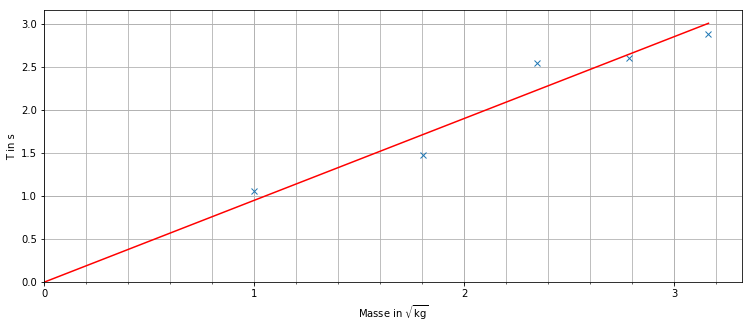

In [14]:
#### random.seed(1234)
np.random.seed(1234)
pars =  {
            'D' : pe('43N/m'),
            'm' : np.linspace(1,10,5)*pe('kg'),
        }
pars['omega'] = np.sqrt(pars['D']/pars['m'])
pars['f'] = pars['omega']/(2*np.pi)
pars['T'] = (1/pars['f']).to('s')
pars['Tu'] = pars['T'] + addnoise(pars['T'],scale=0.1)


####

fig, ax = plt.subplots(1,1,sharex=True,figsize=tuple(np.array([5,2])*2.5))
fig.subplots_adjust(wspace = 0.2,hspace = 0.0)
try: ax = list(ax.flatten())
except: ax = [ax]

X = np.sqrt(pars['m'].to('kg'))
Y = pars['Tu'].to('s')
Xfit = np.linspace(0,X.m.max())
def func(p, x):
    a = p
    return a * x
up , p, Yfit, out = uODR(func,[0],X.m,Y.m,xfit=Xfit)

ax[0].plot(X.m,Y.m,'x')#,linestyle='None')
ax[0].plot(Xfit,Yfit,'r-')#,linestyle='None')

#ax[0].set_xlabel(u'Masse in %s'%("{:~P}".format(X.u)))
ax[0].set_xlabel(r'Masse in $\sqrt{\mathrm{kg}}$')
ax[0].set_ylabel(u'T in %s'%("{:~P}".format(Y.u)))

ax[0].xaxis.set_major_locator(plt.MultipleLocator(1))
ax[0].yaxis.set_major_locator(plt.MultipleLocator(0.5))
ax[0].xaxis.set_minor_locator(plt.MultipleLocator(0.2))
ax[0].yaxis.set_minor_locator(plt.MultipleLocator(1))

ax[0].grid(True,which='both')
lims = ax[0].set_xlim(left=0)
lims = ax[0].set_ylim(bottom=0)

#fig.savefig('A12_fig1.svg', bbox_inches='tight', pad_inches=0, dpi=400)

m = (p[0]*Y.u/X.u).to_base_units()
D = ((2*np.pi/m)**2).to('N/m')

md("Gegeben: <br/>"
+ "$k = {:.2~P}$".format(m)
+ "<br/>Lösung:<br/>" 
+ "$D = {:.3~P}$".format(D))